# COS597N Project Notebook

In [257]:
import pickle
import os
import torch
import torch.nn as nn
from transformers import RobertaTokenizerFast, Trainer, TrainingArguments, RobertaForTokenClassification
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, accuracy_score, matthews_corrcoef
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import re
import tqdm
import torch.nn.functional as F
from datetime import datetime
from copy import deepcopy
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoModel
from tqdm import tqdm

In [258]:
df_full = pickle.load(open('../Datasets/subset_featurized.pkl', "rb"))

In [259]:
df_train = pickle.load(open('../Datasets/subset_train.pkl', "rb"))
df_val = pickle.load(open('../Datasets/subset_val.pkl', "rb"))
df_test = pickle.load(open('../Datasets/subset_test.pkl', "rb"))

In [260]:
protein_lens = pd.Series([len(seq) for seq in df_full['Sequence']])
protein_lens.describe()

count     477.000000
mean      540.436059
std       430.759875
min        24.000000
25%       226.000000
50%       448.000000
75%       713.000000
max      2442.000000
dtype: float64

In [261]:
MAX_LENGTH = 1024
EPOCHS = 10
# EPOCHS = 1
LEARNING_RATE = 2e-6
BATCH_SIZE = 1
TOKENIZER_PATH =  "../checkpoint-final/"
# is this pretrained on protein sequences?
PRETRAINED_MODEL = "../checkpoint-final/"
NUM_CLASSES = 2
SCHEDULER='cosine_with_restarts'

In [262]:
df_train

,disprot_ID,Sequence,full,pLDDT
383,DP02004,MAENLLDGPPNPKRAKLSSPGFSANDSTDFGSLFDLENDLPDELIP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3606, 0.3402, 0.3392, 0.3327, 0.3693, 0.352..."
105,DP01306,MAELLASAGSACSWDFPRAPPSFPPPAASRGGLGGTRSFRPHRGAE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2828, 0.2607, 0.2338, 0.3044, 0.3376, 0.302..."
38,DP01161,MSLICSISNEVPEHPCVSPVSNHVYERRLIEKYIAENGTDPINNQP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5824, 0.7492, 0.8249, 0.8809, 0.9009, 0.909..."
37,DP01160,MSSPRERRPASQAPRLSRRPPAHQTSRSSPDTTAPTGSGLSNRFVN...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.4811, 0.5975, 0.4979, 0.5945, 0.5794, 0.477..."
312,DP01788,MDPGNENSATEAAAIIDLDPDFEPQSRPRSCTWPLPRPEIANQPSE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3925, 0.4244, 0.4723, 0.4422, 0.4941, 0.468..."
...,...,...,...,...
385,DP02006,MSCINLPTVLPGSPSKTRGQIQVILGPMFSGKSTELMRRVRRFQIA...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.4041, 0.4742, 0.4954, 0.5265, 0.4956, 0.548..."
402,DP02069,MATTATMATSGSARKRLLKEEDMTKVEFETSEEVDVTPTFDTMGLR...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.4136, 0.3827, 0.3676, 0.378, 0.3997, 0.3775..."
341,DP01876,MSARGEGAGQPSTSAQGQPAAPAPQKRGRGRPRKQQQEPTGEPSPK...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.6807, 0.7178, 0.6958, 0.6563, 0.6627, 0.675..."
333,DP01857,MAVPETRPNHTIYINNLNEKIKKDELKKSLYAIFSQFGQILDILVS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3945, 0.4299, 0.524, 0.5699, 0.5804, 0.7761..."


In [263]:
class ProteinDegreeDataset(Dataset):

    def __init__(self, max_length, df, tokenizer, region_type):
        self.region_type = region_type # e.g. 'full'
        self.df = df
        self.seqs, self.labels, self.plddts = self.load_dataset()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_dataset(self):
        seq = list(self.df['Sequence']) # list of protein sequences
        label = list(self.df[self.region_type]) # list of list of labels
        plddts = list(self.df['pLDDT'])
        return seq, label, plddts

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)

        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)
        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        tens = torch.tensor(self.labels[idx], dtype=torch.long)
        sample['labels'] = F.pad(tens, (0, MAX_LENGTH - len(tens)))
        plddts = torch.tensor(self.plddts[idx], dtype=torch.float)
        sample['plddts'] = F.pad(plddts, (0, MAX_LENGTH - len(plddts)))
        return sample

In [264]:
tokenizer = RobertaTokenizerFast.from_pretrained(TOKENIZER_PATH, do_lower_case=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [265]:
train_dataset = ProteinDegreeDataset(MAX_LENGTH, df_train, tokenizer, 'full')
# train_dataset = ProteinDegreeDataset(MAX_LENGTH, df_train., tokenizer, 'full')
val_dataset = ProteinDegreeDataset(MAX_LENGTH, df_val, tokenizer, 'full')
# val_dataset = ProteinDegreeDataset(MAX_LENGTH, df_val, tokenizer, 'full')

In [266]:
len(val_dataset)

43

In [178]:
train_dataset[0]['plddts'].shape

/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


torch.Size([1024])

In [179]:
val_dataset[0]

/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


{'input_ids': tensor([ 4, 21, 16,  ...,  1,  1,  1]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'labels': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'plddts': tensor([0.3562, 0.3728, 0.3850,  ..., 0.0000, 0.0000, 0.0000])}

In [180]:
pd.Series(train_dataset[0]['input_ids']).value_counts()

/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


16    130
10    107
18    104
6      99
7      89
5      74
15     70
17     64
8      48
21     44
12     30
13     28
11     28
9      27
22     24
14     24
23     11
19     11
20      8
24      2
4       1
0       1
dtype: int64

There are 25 tokens in the vocabulary (20 amino acids and ["unk_token": "[UNK]", "sep_token": "[SEP]", "pad_token": "[PAD]", "cls_token": "[CLS]", "mask_token": "[MASK]"]).

In [181]:
pd.Series(train_dataset[0]['attention_mask']).value_counts()

/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


1    1024
dtype: int64

All tokens should be attended to.

In [182]:
print(len(train_dataset[0]['attention_mask']), len(train_dataset[0]['input_ids']), len(train_dataset[0]['labels']), len(train_dataset[0]['plddts'])) 

1024 1024 1024 1024


/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


In [183]:
train_dataset[1]

/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)


{'input_ids': tensor([ 4, 21,  6,  ...,  1,  1,  1]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'labels': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'plddts': tensor([0.2828, 0.2607, 0.2338,  ..., 0.0000, 0.0000, 0.0000])}

Finally, note that all training points are truncated to be 1024 amino acids for training.

In [267]:
def precision_recall_f1_roc_convolve(name, logits, labels, convolution):
    convolved = np.convolve(np.array(logits).flatten(), np.array(convolution / np.sum(convolution)).flatten(), 'same')
    p = [(1 - i, i) for i in convolved]
    roc = [i[1] for i in p]
    roc2 = [i[0] for i in p]
    p = np.argmax(p, axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, p)
    roc_auc = roc_auc_score(labels, roc)
    mcc = matthews_corrcoef(labels, p)
    return {
        f'precision_{name}':precision[1],
        f'recall_{name}':recall[1],
        f'f1_{name}':f1[1],
        f'roc_auc_{name}':roc_auc,
        f'mcc_{name}': mcc,
    }

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # creates probabilities
    logits = softmax(logits, axis=2)
    l = []
    # concatenates all true labels for sequence into list
    for j, i in enumerate(labels):
        l = l + list(i[:len(df_val['Sequence'].iloc[j])])
    # concatenates all prob that were predicted to be disordered into list
    lg2 = []
    for k, i in enumerate(logits):
        lg2 = lg2 + [j[1] for j in i[:len(df_val['Sequence'].iloc[k])]]
    print(np.array(lg2).shape)
    # l is list of all concatenated true labels
    # lg2 is list of all concatenated probabilities that corresponding residue in l is equal to 1  
    metrics = {}
    metrics.update(precision_recall_f1_roc_convolve('normal', lg2, l, [1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa5', lg2, l, [1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa9', lg2, l, [1,1,1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa15', lg2, l, [1]*15))
#     metrics.update(precision_recall_f1_roc_convolve('linear5', lg2, l, [1,2,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear9', lg2, l, [1,2,3,4,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear15', lg2, l, [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad5', lg2, l, [1,3,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad9', lg2, l, [1,3,9,27,81,27,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad15', lg2, l, [1,3,9,27,81,243,729,2187,729,243,81,27,9,3,1]))
    
    logits_path = OUTPUT_DIR + '/Logits/'
    if not os.path.isdir(logits_path):
        os.mkdir(logits_path)
    new_df = deepcopy(df_val)
    new_df['Logits'] = [[i[1] for i in x] for x in list(logits)]
    pickle.dump(new_df, open(logits_path + datetime.now().strftime("%H:%M:%S"), 'wb'))
    return metrics

In [268]:
OUTPUT_DIR = f'../subset_outputs/custom_baseline/'

In [269]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [270]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, path, num_classes, plddt = False):
        super(CustomBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(path)
        self.dropout = nn.Dropout(0.1)  # Adjust dropout rate as needed
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.plddt = plddt
        if plddt:
            self.fc = nn.Linear(self.bert.config.hidden_size + 1, num_classes)

    def forward(self, input_ids, attention_mask, plddts=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state
        if plddts is not None and self.plddt:
            pooled_output = torch.concat((pooled_output, plddts.unsqueeze(-1)), dim=2)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [271]:
# from transformers import AutoModelForTokenClassification
def model_init():
#     model = AutoModelForTokenClassification.from_pretrained(PRETRAINED_MODEL, num_labels=NUM_CLASSES)
    model = CustomBERTClassifier(PRETRAINED_MODEL, NUM_CLASSES)
    return model

In [281]:
model = model_init()

Some weights of RobertaModel were not initialized from the model checkpoint at ../checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [282]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CustomBERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(35, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [283]:
# Initialize optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_epochs = EPOCHS
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)

/home/byw2/.conda/envs/dr-bert-env/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [284]:
best_val_loss = float('inf')
best_model_path = OUTPUT_DIR + 'best_model.pth'

In [285]:
best_model_path

'../subset_outputs/custom_baseline/best_model.pth'

In [286]:
train_losses, val_losses = [], []

In [287]:
for epoch in range(num_epochs):
    # set model in training mode
    model.train()
    
    total_loss = 0

    # for each epoch
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask)
        outputs = outputs.view(-1, 2)
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'Training Loss: {average_loss}')

    # Validation loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.view(-1, 2)
            labs = labels.view(-1)
            val_loss = criterion(preds, labs)
            total_val_loss += val_loss.item()
            
#     metrics = compute_metrics((outputs.cpu().numpy(), labels.cpu().numpy()))
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f'Validation Loss: {average_val_loss}')
    
    # Save the best model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(model.state_dict(), best_model_path)
        print('Best model saved.')
    


Epoch 1/10:   0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipykernel_3310506/4153848418.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tens = torch.tensor(self.labels[idx], dtype=torch.long)
Epoch 1/10: 100%|██████████| 386/386 [00:12<00:00, 30.94it/s]


Training Loss: 0.3199656251335391


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


Validation Loss: 0.25361258288224536
Best model saved.


Epoch 2/10: 100%|██████████| 386/386 [00:12<00:00, 30.95it/s]


Training Loss: 0.22530013884519048


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Validation Loss: 0.234670619169871
Best model saved.


Epoch 3/10: 100%|██████████| 386/386 [00:12<00:00, 30.94it/s]


Training Loss: 0.21440623960230942


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Validation Loss: 0.23348179956277212
Best model saved.


Epoch 4/10: 100%|██████████| 386/386 [00:12<00:00, 30.95it/s]


Training Loss: 0.20997017436694604


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Validation Loss: 0.22492478291193643
Best model saved.


Epoch 5/10: 100%|██████████| 386/386 [00:12<00:00, 30.95it/s]


Training Loss: 0.1937767312393905


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Validation Loss: 0.21033368508021036
Best model saved.


Epoch 6/10: 100%|██████████| 386/386 [00:12<00:00, 30.87it/s]


Training Loss: 0.17783353374933178


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


Validation Loss: 0.20537668466567993
Best model saved.


Epoch 7/10: 100%|██████████| 386/386 [00:12<00:00, 30.81it/s]


Training Loss: 0.1703557892379211


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Validation Loss: 0.20348040262858072
Best model saved.


Epoch 8/10: 100%|██████████| 386/386 [00:12<00:00, 30.74it/s]


Training Loss: 0.16779330016688052


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


Validation Loss: 0.20256341000398
Best model saved.


Epoch 9/10: 100%|██████████| 386/386 [00:12<00:00, 30.75it/s]


Training Loss: 0.16711957783587855


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


Validation Loss: 0.20211215317249298
Best model saved.


Epoch 10/10: 100%|██████████| 386/386 [00:12<00:00, 30.75it/s]


Training Loss: 0.16547900999515014


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


Validation Loss: 0.20025297502676645
Best model saved.


In [288]:
best_ft_model = CustomBERTClassifier(PRETRAINED_MODEL, NUM_CLASSES)
best_ft_model.load_state_dict(torch.load(best_model_path))
best_ft_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at ../checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomBERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(35, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [289]:
df_test = pd.read_pickle('../Datasets/subset_test.pkl')

In [290]:
def precision_recall_f1_roc_convolve(name, logits, labels, convolution):
    logits = [i[1] for i in logits]
    convolved = np.convolve(np.array(logits).flatten(), np.array(convolution / np.sum(convolution).flatten()), 'same')
    p = [(1 - i, i) for i in convolved]
    roc = [i[1] for i in p]
    print(len(p))
    p = np.argmax(p, axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, p)
    roc_auc = roc_auc_score(labels, roc)
    mcc = matthews_corrcoef(labels, p)
    return {
        f'precision_{name}':precision[1],
        f'recall_{name}':recall[1],
        f'f1_{name}':f1[1],
        f'roc_auc_{name}':roc_auc,
        f'MCC_{name}':mcc,
    }

In [291]:
def compute_metrics(logits, labels):
    logits = softmax(logits, axis=1)
    print(logits.shape)
    print(labels.shape)
    l = labels
#     l = []
#     for j, i in enumerate(labels):
#         l = l + list(i)
#     print(len(l), len(logits))
    lg2 = logits
    print(lg2.shape)
    metrics = {}
    metrics.update(precision_recall_f1_roc_convolve('normal', lg2, l, [1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa5', lg2, l, [1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa9', lg2, l, [1,1,1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa15', lg2, l, [1]*15))
#     metrics.update(precision_recall_f1_roc_convolve('linear5', lg2, l, [1,2,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear9', lg2, l, [1,2,3,4,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear15', lg2, l, [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad5', lg2, l, [1,3,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad9', lg2, l, [1,3,9,27,81,27,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad15', lg2, l, [1,3,9,27,81,243,729,2187,729,243,81,27,9,3,1]))
    
    return metrics

In [292]:
def model_out(encoded, model):
    """Given encoding, pass through model to get logits. Returns logits."""
    encoded.to(device)
    with torch.no_grad():
        output = model(**encoded)
    return output

In [293]:
def get_word_vector(sent, tokenizer, model):
    """Returns logits."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt", truncation=True, max_length=1024)
    out = model_out(encoded, model)
    return out

In [294]:
Xs = []
labs = []
for index, row in df_test.iterrows():
    seq = row['Sequence']
    lab = list(row['full'])
    word_embedding = get_word_vector(seq[:min(1024, len(seq))], tokenizer, best_ft_model)
    word_embedding = word_embedding[0]
    word_embedding = word_embedding[1:-1]
    word_embedding = word_embedding.cpu()
    word_embedding_full = np.squeeze(word_embedding.numpy())
#     print(word_embedding.shape)
    if len(seq) > 2044:
        for i in range(1022, len(seq) - 1022, 1022):
            word_embedding = get_word_vector(seq[i:i+1022], tokenizer, best_ft_model)
            word_embedding = word_embedding[0]
            word_embedding = word_embedding[1:-1]
            word_embedding = word_embedding.cpu()
            word_embedding = np.squeeze(word_embedding.numpy())
            word_embedding_full = np.concatenate([word_embedding_full, word_embedding], axis=0)
    if len(seq) > 1024:
        word_embedding = get_word_vector(seq[len(seq) - 1022:len(seq)], tokenizer, best_ft_model)
        word_embedding = word_embedding[0]
        word_embedding = word_embedding[1:-1]
        word_embedding = word_embedding.cpu()
        word_embedding = np.squeeze(word_embedding.numpy())
        overlap_amount = 1022 - (len(seq) % 1022)
        overlap = word_embedding_full[(-1 * overlap_amount):]
        word_embedding_full[(-1 * overlap_amount):] = (overlap + word_embedding[:overlap_amount]) / 2
        end_chunk = word_embedding[overlap_amount:]
        word_embedding_full = np.concatenate([word_embedding_full, end_chunk], axis=0)
#     print(word_embedding_full.shape, len(seq))
    Xs.append(word_embedding_full)
    labs.append(lab[:len(seq)])

In [295]:
Xs = np.concatenate(Xs)
labs = np.concatenate(labs)

In [296]:
labs.shape

(22980,)

In [297]:
Xs.shape

(22980, 2)

In [298]:
metrics = compute_metrics(Xs, labs)

(22980, 2)
(22980,)
(22980, 2)
22980


In [299]:
metrics

{'precision_normal': 0.4345718901453958,
 'recall_normal': 0.21734446539186641,
 'f1_normal': 0.28976660682226213,
 'roc_auc_normal': 0.7753798237871533,
 'MCC_normal': 0.21992059569829922}

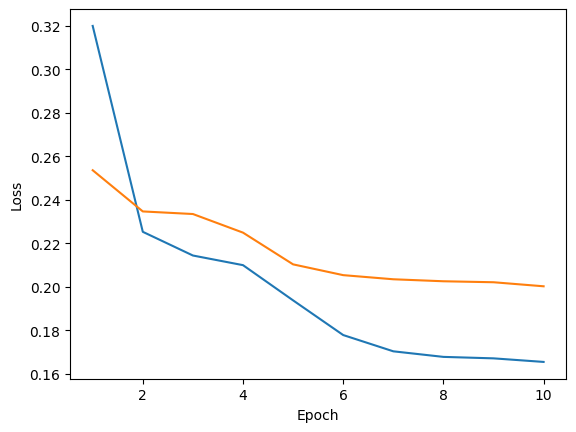

In [300]:
plt.plot(list(range(1, 11)), train_losses)
plt.plot(list(range(1, 11)), val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [301]:
OUTPUT_DIR

'../subset_outputs/custom_baseline/'

In [302]:
losses = {
    'train': train_losses,
    'val': val_losses
}

In [303]:
with open(f'{OUTPUT_DIR}losses.pkl', 'wb') as f:
    pickle.dump(losses, f)

In [304]:
# # Load data (deserialize)
# with open(f'{OUTPUT_DIR}losses.pkl', 'rb') as f:
#     tmp = pickle.load(f)